TASK 1. 
В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:
state — штат США
account_length — длительность использования аккаунта
area_code — деление пользователей на псевдорегионы, использующееся в телекоме
intl_plan — подключена ли у пользователя услуга международного общения
vmail_plan — подключена ли у пользователя услуга голосовых сообщений
vmail_message — количество голосых сообщений, который пользователь отправил / принял
day_calls — сколько пользователь совершил дневных звонков
day_mins — сколько пользователь проговорил минут в течение дня
day_charge — сколько пользователь заплатил за свою дневную активность
eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
custserv_calls — сколько раз пользователь позвонил в службу поддержки
treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
mes_estim — оценка интенсивности пользования интернет мессенджерами
churn — результат оттока: перестал ли абонент пользоваться услугами оператора
Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции

1
scipy.stats.chi2_contingency(subtable, correction=False)
Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем α=0.05?

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('churn_analysis.csv')

In [4]:
data.shape

(3333, 23)

In [3]:
data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [5]:
from scipy.stats import chi2_contingency
from itertools import combinations

Пояснение:
таблицы сопряженности рассмотрен в видео “Пример: поправки на множественную проверку при корреляционном анализе” на 3 уроке 3 недели stat.correlation (вам нужна функция pivot_table)
Для того чтобы из таблицы сопряженности выделить какие-либо два штата, можете просто указать их имена в функции pt.loc[["CT", "DC"], :]
Обратите внимание, что вам нужно взять всевозможные пары штатов. Формально говоря, это сочетания без повторений из n по 2. Количество этих сочетаний равно n!2!(n−2)! Для того чтобы в питоне получить сочетания из n по k можно воспользоваться функциейcombinations из модуля itertools, передав в функцию параметр k.

In [61]:
#When using the .loc indexer, columns are referred to by names using lists of strings, or “:” slices.
state_churn_table = data.loc[data.treatment == 1, :].pivot_table(values='area_code', index=['state'],
                     columns=['churn'], fill_value = 0,aggfunc = len)

In [62]:
state_churn_table.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [75]:
# вариант 2 для создания таблицы сопряженности
data1=data.loc[data.treatment==1,:]
print(data1.shape)
state_churn_table1=pd.crosstab(data1.state, data1.churn, margins=False)
state_churn_table1.head()

(1097, 23)


churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [60]:
state_churn_table1.shape

(51, 2)

In [113]:
# Создадим комбинации всех 1275 возможных неупорядоченных пар штатов
state_pairs = list(combinations(data.state.unique(), 2))
print(len(state_pairs))
print(state_pairs[1])

1275
('KS', 'NJ')


In [114]:
pvalues = []
for pair in state_pairs:
    subtable = state_churn_table1.loc[[pair[0],pair[1]], :]
    pvalues.append(chi2_contingency(subtable, correction=False)[1])
#pvalues

In [115]:
len(pvalues)

1275

In [116]:
sum([x < 0.05 for x in pvalues])#кол-во достигаемых уровней значимости оказались меньше, чем α=0.05

34

In [117]:
print(set(data.state.values),2)

{'IL', 'IA', 'SD', 'MS', 'NV', 'VT', 'AZ', 'OK', 'KS', 'GA', 'CT', 'MA', 'ID', 'NM', 'DE', 'OR', 'PA', 'MI', 'KY', 'ME', 'NH', 'TN', 'AL', 'NJ', 'LA', 'MD', 'MT', 'FL', 'WY', 'AR', 'CA', 'UT', 'WA', 'SC', 'TX', 'VA', 'IN', 'DC', 'WV', 'RI', 'NC', 'NY', 'AK', 'CO', 'NE', 'ND', 'WI', 'OH', 'HI', 'MN', 'MO'} 2


$$TASK 2$$
Какие проблемы Вы видите в построении анализа из первого вопроса? Отметьте все верные утверждения.

Анализ нужно было начинать с применения xи-квадрат к таблице сопряженности, в которой присутствовали сразу все возможные штаты. Достигаемой уровень значимости такой проверки = 0.7, что дает нам гарантию, что нет ни одной пары штатов, в которых отличие в соотношениях ушедших и оставшихся клиентов статистически значимо.

Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.

Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез.

Хи-квадрат используется для того, чтобы сравнить выборку с некоторым воздействием (treatment) и выборку без этого воздействия (control). Мы же в первом задании сравнивали штаты, используя данные только control группы. Для данных только из control группы использование xи-квадрат неправомерно.

Поправку на множественную проверку здесь применять нельзя — она используется только для группы критериев, проверяющих равенство средних (типа t-критерия). Критерий xи-квадрат не принадлежит этому семейству, поэтому поправка не нужна.

Для ответа на вышеуказанные вопросы проверим следующие критерии, необходимые для применения критерия хи-квадрат:
Критерий согласия Пирсона (или критерий хи-квадрат) используется для проверки того,
что некоторая на- блюдаемая случайная величина подчиняется тому или иному теоретическому закону распределения.
 Статистика этого критерия:
K (n−np)2 χ2= i i.
i=1 npi
Критерий хи-квадрат для таблиц сопряженности может применяться при выполнении следующих условий.
Нужно, чтобы выборки были достаточно большими: n ≥ 40. Кроме того, необходимо, чтобы ожидаемое
 количество элементов в каждой ячейке таблицы было меньше 5 (ni+n+j < 5), не более, чем в 20% ячеек.

TASK3 В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного Oi и ожидаемого Ei значений, то есть, статистика с такой поправкой выглядит так:
$$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}.$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией
scipy.stats.chi2_contingency(subtable, correction=True)
и сравните полученные результаты, отметив все верные варианты.


In [118]:
pvalues_corrected = []
for pair in state_pairs:
    subtable = state_churn_table1.loc[[pair[0],pair[1]], :]
    pvalues_corrected.append(chi2_contingency(subtable, correction=True)[1])

In [119]:
sum([x < 0.05 for x in pvalues_corrected])#кол-во достигаемых уровней значимости оказались меньше, чем α=0.05

0

Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.- $CORRECT$

Количество достигаемых уровней значимости, меньших, чем 0.05, почти не изменилось, нельзя сказать, что введенная поправка сильно поменяла достигаемые уровни значимости. $WRONG$

In [120]:
type(pvalues)

list

In [122]:
np.asarray(pvalues).shape

(1275,)

In [123]:
np.asarray(pvalues_corrected).shape

(1275,)

In [126]:
delta_p=np.asarray(pvalues_corrected)-np.asarray(pvalues)

In [129]:
delta_p

array([ 0.08353017,  0.20130076,  0.25596116, ...,  0.29086175,
        0.27292215,  0.29739148])

In [133]:
len([x for x in delta_p if x < 0])

192

Поправка Йетса на непрерывность всегда увеличивает значение достигаемого уровня значимости, поэтому все получившиеся значения достигаемого уровня значимости строго больше или равны таковым значениям при отсутствии этой поправки. $WRONG$

In [130]:
np.mean(delta_p)

0.16222925833118856

Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки. $CORRECT$

$$TASK 4$$
Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

            Группа 1	Группа 2	Σ

Воздействие 1	      a	      b	       a+b

Воздействие 2	     c	       d	   c+d

 Σ	            a+c	       b+d	    n=a+b+c+d
 
Тогда вероятность получить именно такие a,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением
$$p={\frac {\displaystyle {{a+b} \choose {a}}\displaystyle {{c+d} \choose {c}}}{\displaystyle {{n} \choose {a+c}}}}={ \dfrac {(a+b)!~(c+d)!~(a+c)!~(b+d)!}{a!~~b!~~c!~~d!~~n!}}.$$

В числителе этой дроби стоит суммарное количество способов выбрать a и c из a+b и c+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a+c из общего количества рассматриваемых объектов n.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a,b,c,d нужно вычислить значение pi по формуле выше и просуммировать все такие значения pi, которые меньше или равны p, которое мы вычислили по наблюдаемым значениям a,b,c,d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции



1
scipy.stats.fisher_exact
которая принимает на вход таблицу сопряженности 2x2.


Точный критерий Фишера точно также, как и критерий xи-квадрат, нельзя использовать, если наблюдений < 40 и если ожидаемое значение меньше 5 больше чем в 20% ячейках. $WRONG$

Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля. $CORRECT$

In [134]:
from scipy.stats import fisher_exact

In [135]:
pvalues_fisher = []
for pair in state_pairs:
    subtable = state_churn_table1.loc[[pair[0],pair[1]], :]
    pvalues_fisher.append(fisher_exact(subtable)[1])

In [136]:
sum([x < 0.05 for x in pvalues_fisher])#кол-во достигаемых уровней значимости оказались меньше, чем α=0.05

10

In [137]:
delta_p=np.asarray(pvalues_fisher)-np.asarray(pvalues)

In [138]:
np.mean(delta_p)

0.14651092612815042

In [183]:
pt2 = data.pivot_table(index="treatment", 
     values="area_code", columns="churn", aggfunc = len, fill_value=0)

In [184]:
pt2

churn,False.,True.
treatment,,
0,968,165
1,917,180
2,965,138


Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат без поправки $WRONG$
Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки $CORRECT$

In [139]:
delta_p=np.asarray(pvalues_fisher)-np.asarray(pvalues_corrected)

In [140]:
np.mean(delta_p)

-0.015718332203038116

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса $CORRECT$

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем большие, чем xи-квадрат с поправкой Йетса $WRONG$


$$TASK 5 $$
Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения.

In [141]:
from scipy.stats import pearsonr

In [145]:
corr,p=pearsonr(data['day_calls'], data['mes_estim'])
corr,p

(-0.051794350587572625, 0.0027798836869756707)

Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. $CORRECT$

$$TASK 6$$ 

Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [148]:
from scipy.stats import spearmanr

In [149]:
spearmanr(data['day_calls'], data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. $CORRECT$

$$TASK 7$$
7. 
Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?

Не стоит ориентироваться на значение корреляции Спирмена, потому что корреляцию Спирмена можно считать только тогда, когда оба признака дискретные и между значениями можно установить строгий порядок. $WRONG$

Предположение нормальности данных двух признаков не выполнено, что хорошо видно на ку-ку графике, поэтому корреляция Пирсона может быть полностью неадекватна.$WRONG$

Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам. $СORRECT$

Подсчет корреляций не имеет особого смысла, поскольку корреляция ничего не говорит о том, какая на самом деле зависимость имеется между признаками.$WRONG$

In [153]:
from scipy.stats import probplot

In [167]:
import scipy.stats
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


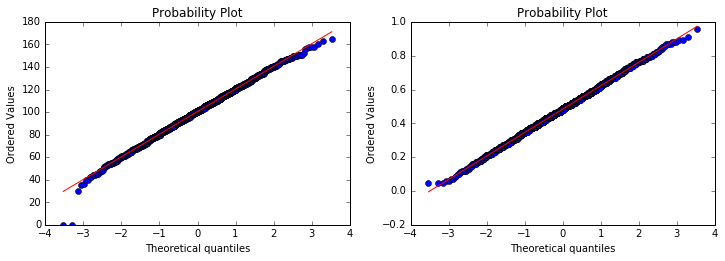

In [170]:
%pylab inline
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
scipy.stats.probplot(data['day_calls'].values, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
scipy.stats.probplot(data['mes_estim'].values, dist="norm", plot=pylab)
pylab.show()


$$TASK 8$$
Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

Достигаемый уровень значимости < 0.05, то есть, отличие от нуля значения коэффицента Крамера значимо.

Достигаемый уровень значимости > 0.05, то есть, отличие от нуля значения коэффицента Крамера незначимо.

Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.

Коэффициент корреляции Крамера не может быть использован для сравнения связи этих двух признаков, потому что он используется для таблиц сопряженности, где каждая из размерностей больше двух. Если хотя бы одна из размерностей равна 2, то нужно использовать коэффициент корреляции Мэтьюса. $CORRECT$

In [177]:
state_churn = data[data.treatment == 1].pivot_table(index='state',values= 'area_code',columns='churn', aggfunc=len, fill_value=0)

In [ ]:
state_churn_table = data.loc[data.treatment == 1, :].pivot_table(values='area_code', index=['state'],
                     columns=['churn'], fill_value = 0,aggfunc = len)

In [185]:
pt3 = data1.pivot_table(index="treatment", 
     values="area_code", columns="churn", aggfunc = len, fill_value=0)

In [186]:
pt3

churn,False.,True.
treatment,,
1,917,180


In [230]:
#state_churn_table

In [181]:
sum(chi2_contingency(state_churn_table.values)[3])

1097.0

In [190]:
chi2_contingency(state_churn_table.values)

(44.052712366925483,
 0.70975900427784411,
 50,
 array([[ 16.7183227 ,   3.2816773 ],
        [ 25.07748405,   4.92251595],
        [ 13.37465816,   2.62534184],
        [ 15.88240656,   3.11759344],
        [ 12.53874202,   2.46125798],
        [ 18.39015497,   3.60984503],
        [ 25.07748405,   4.92251595],
        [ 15.88240656,   3.11759344],
        [ 14.21057429,   2.78942571],
        [ 16.7183227 ,   3.2816773 ],
        [ 17.55423883,   3.44576117],
        [ 10.86690975,   2.13309025],
        [ 12.53874202,   2.46125798],
        [ 15.04649043,   2.95350957],
        [ 10.03099362,   1.96900638],
        [ 19.2260711 ,   3.7739289 ],
        [ 20.89790337,   4.10209663],
        [ 20.89790337,   4.10209663],
        [ 12.53874202,   2.46125798],
        [ 20.06198724,   3.93801276],
        [ 20.06198724,   3.93801276],
        [ 23.40565178,   4.59434822],
        [ 18.39015497,   3.60984503],
        [ 17.55423883,   3.44576117],
        [ 17.55423883,   3.44576117],
  

In [191]:
np.sqrt(44.052712366925483/(1097.0)) # Coef V Kramer (0-полное отсутствие взаимосвязи, значение 1 -полное совпдение)

0.20039321502033319

In [194]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(np.array(state_churn_table))

In [199]:
cramer = np.sqrt(chi2 / ((state_churn_table.sum().sum()) * (min(state_churn_table.shape)-1)))

In [200]:
p, cramer

(0.70975900427784411, 0.20039321502033319)

$$TASK 9$$
Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !

Ни один из методов не показал значительного улучшения относительно других, о чем говорит групповой статистический критерий.

treatment = 0 статистически значимо отличается от контрольной группы treatment = 1

treatment = 2 статистически значимо отличается от контрольной группы treatment = 1

В дальнейшем телеком компании рекомендуется использовать и treatment = 0, и treatment = 2 для наибольшей эффективности удержения абонентов.

Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо.

# Доверительный интервал для разности долей (независимые выборки)

 $ $ | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$$


$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$

In [ ]:
Проведем анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1). по статистическому критерию z 

In [219]:

import scipy
from statsmodels.stats.weightstats import *
def proportions_diff_z_test(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
    
    return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

In [220]:
treatment_0_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 0].churn.values]
treatment_1_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 1].churn.values]
treatment_2_churn = [1 if x == 'True.' else 0 for x in data[data.treatment == 2].churn.values]

In [221]:

p01=proportions_diff_z_test(treatment_0_churn, treatment_1_churn)

In [222]:
p01

0.22833116390451069

In [223]:

p12=proportions_diff_z_test(treatment_1_churn, treatment_2_churn)

In [224]:
p12

0.0093480842944511089

In [225]:

p02=proportions_diff_z_test(treatment_0_churn, treatment_2_churn)

In [226]:
p02

0.15642468860508019

In [228]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [229]:
#поправка на множественную проверку с помощью метода Холма
reject, p_corrected, a1, a2 = multipletests([p01, p12, p02], alpha = 0.05, method = 'holm')
reject, p_corrected

(array([False,  True, False], dtype=bool),
 array([ 0.31284938,  0.02804425,  0.31284938]))

"treatment = 2 статистически значимо отличается от контрольной группы treatment = 1" - $CORRECT$

"Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо." - $CORRECT$